# Model 

link : https://github.com/fangpin/siamese-pytorch/blob/master/train.py

Things from the course : 
- 8.2 : "They share a common structure of several convolutional layers seen as a feature extractor, followed by fully connected layers seen as a classifier." $\rightarrow$ implement the submodel as specified in the course : one module for the extractor, one module for the classifier
- 8.2 : in Alexnet model & VGGNet19, dropout layer in the classifier part 
- 8.2 In VGGNet19, notice stride and padding are explicited : do this : note that the kernel size is 3x for 224x224 ... Should we still keep the same for much smaller image ? 
- 8.2 slide 10/34 Piece of code to look at the image using PIL 
- 8.2 slide 10/34 Note that when using Alexnet, image is noramlized following distribution N(mu = 0.5, sigma^2 =  0.5)
- 8.2 slide 10/34 : use the same writing style for our code 
- 8.2 Have a fully convolutional networks, as suggested in the bullet points.
- 8.3 slide 11/15 (~15 min in dedicated video) Can draw inspiration from the loss of the YOLO model 

to try : 
- reshape the network by adding a layer 
- changing the number of hidden units 
- normalize the data 
- **Optimize with a loss based on target and not on class (as suggested in second paragraph ?) ***
- try for different losses (contrastive loss notamment)
- Hyperparameter optimization (for eta notamment)
- try with different optimizer


\* "The goal of the project is to compare different architectures, and assess the performance improvement
that can be achieved through weight sharing, or using auxiliary losses. For the latter, the training can
in particular take advantage of the availability of the classes of the two digits in each pair, beside the
Boolean value truly of interest." $\rightarrow$ Why only for the latter i.e., auxialiary loss ? If we use the target instead of classes, the problem is in the way to interpret the meaning of the value of loss with regard to the value 0 and 1 

In [1]:
import torch 
from torch import nn 
from torch.nn import functional as F 
from torch import optim 

import dlc_practical_prologue as prologue

In [2]:
# Parameters: 

N = 1000
nb_hidden_units = 200
nb_epochs = 25
mini_batch_size = 100
eta = 1e-4

In [3]:
# Loading data 

train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)

In [18]:
class ConvNet(nn.Module):
    
    def __init__(self, nb_hidden_units):
        
        super().__init__()
        
        # No Weight Sharing
        self.conv1_1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3)
        self.conv1_2 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3)

        self.conv2_1 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)  
        self.conv2_2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)  

        self.fc1_1 = nn.Linear(256, nb_hidden_units)
        self.fc1_2 = nn.Linear(256, nb_hidden_units)

        self.fc2_1 = nn.Linear(nb_hidden_units, 10)
        self.fc2_2 = nn.Linear(nb_hidden_units, 10)
        
    
    
    def forward_1(self, x):
        
        x1 = x[:,0,:,:]
        x1 = x1.view(x1.size(0),1,x1.size(1),x1.size(2))

        x1 = F.relu(F.max_pool2d(self.conv1_1(x1), kernel_size=2)) # 1x14x14 -- conv2D --> 32x12x12 -- maxpool --> 32x6x6 
        x1 = F.relu(F.max_pool2d(self.conv2_1(x1), kernel_size=2)) # 32x6x6 -- conv2D --> 64x4x4 -- maxpool --> 64x2x2 
        x1 = x1.view(-1, 256)     # 64x2x2 --> 256
        x1 = F.relu(self.fc1_1(x1)) # 256 --> nb_hidden_units
        x1 = self.fc2_1(x1)         # nb_hidden_units --> 10 
        
        return x1 
    
    
    def forward_2(self,x):

        x2 = x[:,1,:,:]
        x2 = x2.view(x2.size(0),1,x2.size(1),x2.size(2))
        
        x2 = F.relu(F.max_pool2d(self.conv1_2(x2), kernel_size=2)) # 1x14x14 -- conv2D --> 32x12x12 -- maxpool --> 32x6x6 
        x2 = F.relu(F.max_pool2d(self.conv2_2(x2), kernel_size=2)) # 32x6x6 -- conv2D --> 64x4x4 -- maxpool --> 64x2x2 
        x2 = x2.view(-1, 256)     # 64x2x2 --> 256
        x2 = F.relu(self.fc1_2(x2)) # 256 --> nb_hidden_units
        x2 = self.fc2_2(x2)         # nb_hidden_units --> 10 

        return x2
    

    def predicted_target(self,x1,x2): 
        
        _, predicted_classes_1 = torch.max(x1,1)
        _, predicted_classes_2 = torch.max(x2,1)

        return (predicted_classes_1 <= predicted_classes_2)
        
      
    def forward(self,x):
        
        output1 = self.forward_1(x)       
        output2 = self.forward_2(x)
        target = self.predicted_target(output1,output2)
        
        return output1, output2, target


In [19]:
class SiameseNet(nn.Module):
    
    def __init__(self, nb_hidden_units):
        
        super().__init__()
        
        # Weight Sharing
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)  
        self.fc1 = nn.Linear(256, nb_hidden_units)
        self.fc2 = nn.Linear(nb_hidden_units, 10)
        
    
    def forward_1(self, x):
        
        x1 = x[:,0,:,:]
        x1 = x1.view(x1.size(0),1,x1.size(1),x1.size(2))

        x1 = F.relu(F.max_pool2d(self.conv1(x1), kernel_size=2)) # 1x14x14 -- conv2D --> 32x12x12 -- maxpool --> 32x6x6 
        x1 = F.relu(F.max_pool2d(self.conv2(x1), kernel_size=2)) # 32x6x6 -- conv2D --> 64x4x4 -- maxpool --> 64x2x2 
        x1 = x1.view(-1, 256)     # 64x2x2 --> 256
        x1 = F.relu(self.fc1(x1)) # 256 --> nb_hidden_units
        x1 = self.fc2(x1)         # nb_hidden_units --> 10 
        
        return x1 
    
    def forward_2(self,x):

        x2 = x[:,1,:,:]
        x2 = x2.view(x2.size(0),1,x2.size(1),x2.size(2))
        
        x2 = F.relu(F.max_pool2d(self.conv1(x2), kernel_size=2)) # 1x14x14 -- conv2D --> 32x12x12 -- maxpool --> 32x6x6 
        x2 = F.relu(F.max_pool2d(self.conv2(x2), kernel_size=2)) # 32x6x6 -- conv2D --> 64x4x4 -- maxpool --> 64x2x2 
        x2 = x2.view(-1, 256)     # 64x2x2 --> 256
        x2 = F.relu(self.fc1(x2)) # 256 --> nb_hidden_units
        x2 = self.fc2(x2)         # nb_hidden_units --> 10 

        return x2
    
    def predicted_target(self,x1,x2): 
        
        _, predicted_classes_1 = torch.max(x1,1)
        _, predicted_classes_2 = torch.max(x2,1)
        
        return (predicted_classes_1 <= predicted_classes_2)
    
    def forward(self,x):
        
        output1 = self.forward_1(x)       
        output2 = self.forward_2(x)
        target = self.predicted_target(output1,output2)

        
        return output1, output2, target


In [8]:
#output = model(train_input)
#output

In [20]:
model_1 = ConvNet(nb_hidden_units)
model_2 = SiameseNet(nb_hidden_units)

In [21]:
def train_model(model, train_input, train_target, mini_batch_size, nb_epochs): 
    
    criterion = nn.CrossEntropyLoss()
    optimizer= optim.SGD(model.parameters(), lr = eta)
      
    loss_records = []
    
    for e in range(nb_epochs):
        
        for b in range(0, train_input.size(0), mini_batch_size):
            
            output1, output2, predicted_target = model(train_input.narrow(0, b,mini_batch_size))
                           
            loss1 = criterion(output1, train_classes.narrow(0, b, mini_batch_size)[:,0])
            loss2 = criterion(output2, train_classes.narrow(0, b, mini_batch_size)[:,1])
            
            loss = loss1 + loss2
            
            loss_records.append(loss.item())
                    
            model.zero_grad()
            loss.backward()
            optimizer.step()   
            
    return loss_records

In [22]:
loss1 = train_model(model_1, train_input, train_target, mini_batch_size, nb_epochs)
loss2 = train_model(model_2, train_input, train_target, mini_batch_size, nb_epochs)

## Weightsharing intuition seems to work, as loss converging to 4 ~3 times faster for weight sharing ==> however the number of errors remains the same

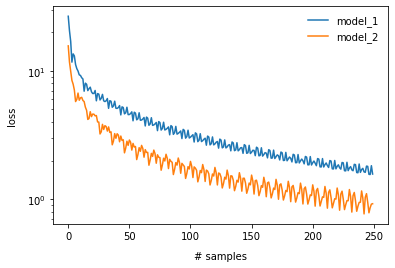

In [23]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('# samples', labelpad = 10)
ax.set_yscale('log')
ax.set_ylabel('loss', labelpad = 10)

ax.plot(loss1,label='model_1') 
ax.plot(loss2,label='model_2') 


ax.legend(frameon = False)

plt.show()

In [11]:
def compute_nb_errors(model,data_input,data_target,mini_batch_size): 
    
    nb_errors = 0
    
    #if isinstance(model,ConvNet): 
        
    for b in range(0, data_input.size(0), mini_batch_size):
        output_1, output_2 = model(data_input.narrow(0,b,mini_batch_size))
        _, predicted_classes_1 = torch.max(output_1,1)
        _, predicted_classes_2 = torch.max(output_2,1)
        
        # Problem here : for a given batch, always the same output ... ==> THe eta was just not set appropriately
        #print(output_1)
        #print(predicted_classes_1)
        #print(output_2)
        #print(predicted_classes_2)
        
        predicted_target = (predicted_classes_1 <= predicted_classes_2)
        
        #print(predicted_target)

        for k in range(mini_batch_size):
            if data_target[b+k] != predicted_target[k]:
                nb_errors += 1
    
    return nb_errors

In [12]:
nb_train_errors_1 = compute_nb_errors(model_1, train_input, train_target, mini_batch_size)
nb_train_errors_2 = compute_nb_errors(model_2, train_input, train_target, mini_batch_size)

print( 'train error Net_1 {:0.2f}% {:d}/{:d}'.format((100*nb_train_errors_1) / train_input.size(0), nb_train_errors_1, train_input.size(0)  ) )
print( 'train error Net_2 {:0.2f}% {:d}/{:d}'.format((100*nb_train_errors_2) / train_input.size(0), nb_train_errors_2, train_input.size(0)  ) )

train error Net_1 12.30% 123/1000
train error Net_2 10.20% 102/1000


In [13]:
nb_test_errors_1 = compute_nb_errors(model_1, test_input, test_target, mini_batch_size)
nb_test_errors_2 = compute_nb_errors(model_2, test_input, test_target, mini_batch_size)

print( 'test error Net_1 {:0.2f}% {:d}/{:d}'.format((100*nb_test_errors_1) / test_input.size(0), nb_test_errors_1, test_input.size(0)  ) )
print( 'test error Net_2 {:0.2f}% {:d}/{:d}'.format((100*nb_test_errors_2) / test_input.size(0), nb_test_errors_2, test_input.size(0)  ) )


test error Net_1 17.40% 174/1000
test error Net_2 11.00% 110/1000
